In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
import scrapbook as sb

C:\Users\Hakan Serpen\.conda\envs\mfe-preprogram\lib\site-packages\papermill\iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
token = 'ETH'
from_date = '2021-11-05'
to_date = '2021-11-11'
connection_string = 'sqlite:///data/data.db'

In [3]:
# Parameters
from_date = "2021-12-01 00:00:00"
to_date = "2021-12-15 00:00:00"
token = "ETH"
connection_string = "sqlite:///data/data.db"


In [4]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

In [5]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [6]:
prices['volatility'] = vol_ohlc(prices,2)


In [7]:
prices['return']=np.log(prices['close']/prices['open'])

In [8]:
prices['drawdown']=(prices.high-prices.low)/prices.high
prices['max_drawdown']=prices['drawdown'].expanding().max()

In [9]:
def series_plot(data, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)



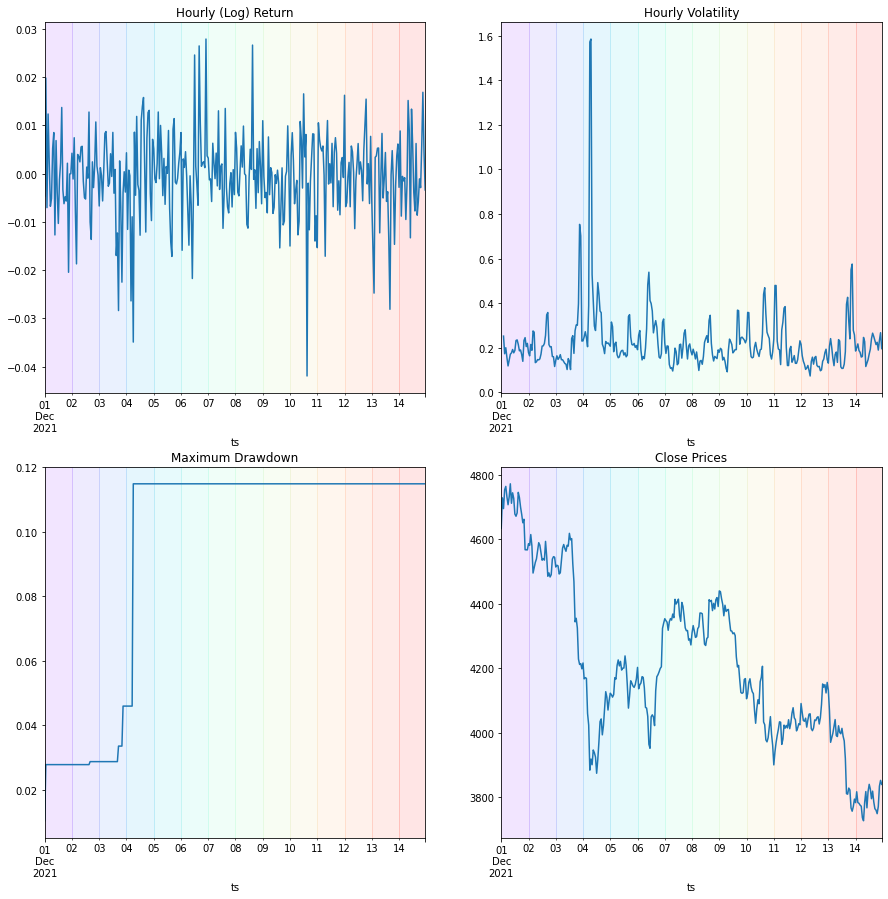

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

series_plot(prices['return'],ax=ax[0,0])
ax[0,0].title.set_text('Hourly (Log) Return')

series_plot(prices['volatility'],ax=ax[0,1])
ax[0,1].title.set_text('Hourly Volatility')

series_plot(prices['max_drawdown'],ax=ax[1,0])
ax[1,0].title.set_text('Maximum Drawdown')

series_plot(prices['close'],ax=ax[1,1])
ax[1,1].title.set_text('Close Prices')


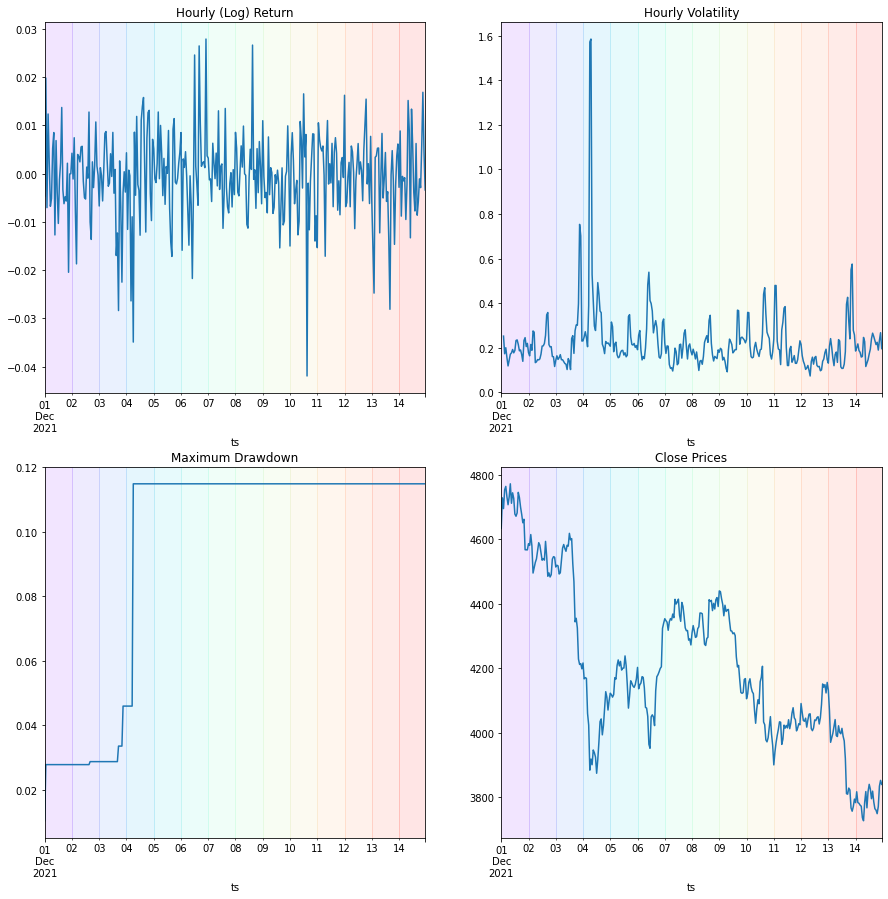

In [11]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)

In [12]:
prices

,open,high,low,close,volume,volumeUSD,token,chain,volatility,return,drawdown,max_drawdown
ts,,,,,,,,,,,,
2021-12-01 00:00:00,4656.62,4672.43,4624.16,4634.95,6013.006735,2.793321e+07,ETH,ETH,NaN,-0.004664,0.010331,0.010331
2021-12-01 01:00:00,4636.43,4736.90,4605.49,4729.10,13819.061610,6.487693e+07,ETH,ETH,NaN,0.019790,0.027742,0.027742
2021-12-01 02:00:00,4729.10,4729.10,4684.49,4695.78,7491.465440,3.524161e+07,ETH,ETH,0.252367,-0.007071,0.009433,0.027742
2021-12-01 03:00:00,4695.78,4754.97,4672.30,4754.09,10530.834423,4.963273e+07,ETH,ETH,0.173308,0.012341,0.017386,0.027742
2021-12-01 04:00:00,4754.09,4774.74,4722.02,4764.59,12471.624735,5.924627e+07,ETH,ETH,0.200242,0.002206,0.011041,0.027742
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-14 19:00:00,3760.58,3784.91,3726.41,3749.59,7607.136587,2.854686e+07,ETH,ETH,0.224824,-0.002927,0.015456,0.114836
2021-12-14 20:00:00,3749.61,3784.96,3748.52,3771.94,6225.222234,2.346554e+07,ETH,ETH,0.189701,0.005938,0.009628,0.114836
2021-12-14 21:00:00,3771.02,3862.59,3770.41,3835.07,13584.425784,5.193951e+07,ETH,ETH,0.233591,0.016842,0.023865,0.114836
